In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import os

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
path1 = os.path.join("data", "mouse_drug_data.csv")
path2 = os.path.join("data", "clinicaltrial_data.csv")

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(path1)
clinical_df = pd.read_csv(path2)

# Combine the data into a single dataset
df = pd.merge(mouse_df, clinical_df, on = "Mouse ID", how = 'outer')

# Display the data table for preview
df

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2
...,...,...,...,...,...
1901,j235,Placebo,0,45.000000,0
1902,j235,Placebo,5,46.588820,0
1903,j235,Placebo,10,48.018788,1
1904,j235,Placebo,15,51.161138,1


## Tumor Response to Treatment

In [2]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 

col_list = ['Drug', 'Timepoint']
tumor = 'Tumor Volume (mm3)'

def group_mean(df, group_cols, out_col):
    return pd.DataFrame(df.groupby(group_cols).mean()[out_col])


def group_sem(df, group_cols, out_col):
    return pd.DataFrame(df.groupby(group_cols).sem()[out_col])

def group_count(df, group_cols, out_col):
    return pd.DataFrame(df.groupby(group_cols).count()[out_col])

tum_vol = group_mean(df, col_list, tumor)
tum_sem = group_sem(df, col_list, tumor)

# Minor Data Munging to Re-Format the Data Frames
def tranpose_multindex(df, col):
    df = df.reset_index().pivot('Timepoint', 'Drug', col)
    return df

T_tum_vol = tranpose_multindex(tum_vol, tumor)
T_tum_sem = tranpose_multindex(tum_sem, tumor)
##how can i generalize this function??

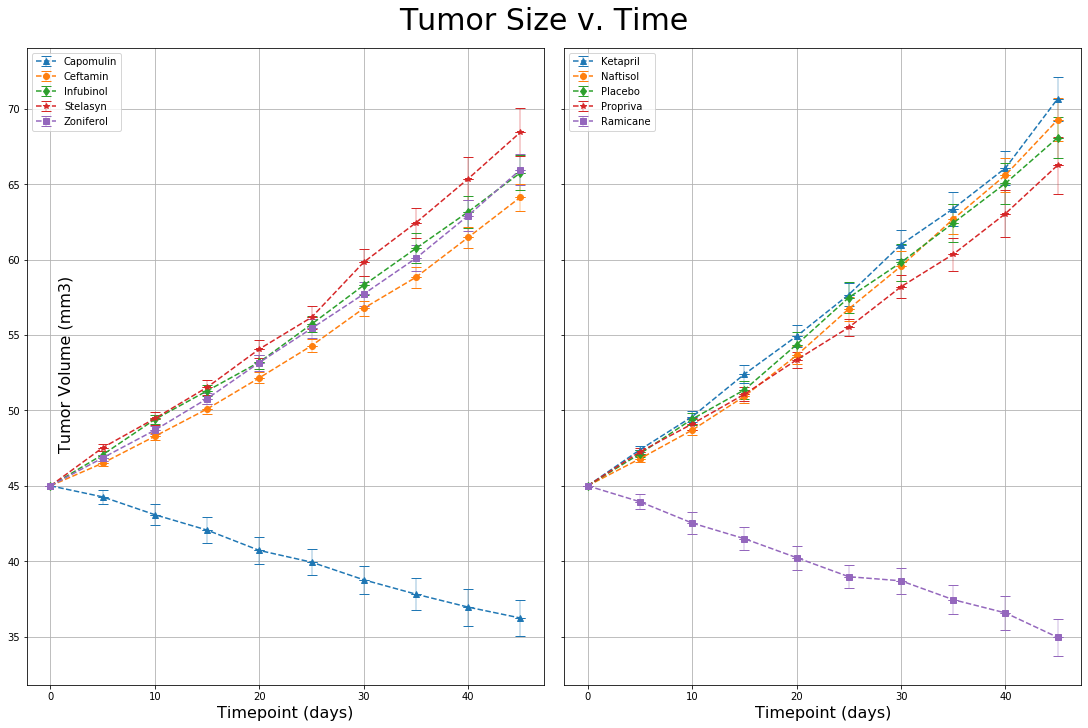

In [43]:
# Generate the Plot (with Error Bars)

formatz = ['--^', '--o', '--d', '--*', '--s']
xaxis = df.Timepoint.unique()

fig, axs = plt.subplots(1, 2, figsize = (15,10), sharex= 'all', sharey='all', constrained_layout=True)
fig.suptitle('Tumor Size v. Time', fontsize = 30)
axs[0].set_xlabel('Timepoint (days)', fontsize = 16)
axs[1].set_xlabel('Timepoint (days)', fontsize = 16)
fig.text(0.05, .5, 'Tumor Volume (mm3)', va='center', rotation='vertical', fontsize = 16)
axs[0].grid()
axs[1].grid()



for col, coll, f in zip(T_tum_vol.iloc[:, [0,1,2,8,9]], T_tum_vol.iloc[:, [3,4,5,6,7]], formatz):
    #storing the 'ErrorBarContainer' in mark, cap, bar works because maybe the container references 3 tuples to store the plot data, we
    #can then use them to specify what we may to make opaque
    markers, caps, bars = axs[0].errorbar(xaxis, T_tum_vol[col], yerr = T_tum_sem[col], uplims=True,\
                    lolims=True, label = col,  fmt=f, capsize = 5)
    mark, cap, bar = axs[1].errorbar(xaxis, T_tum_vol[coll], yerr = T_tum_sem[coll], uplims=True,\
                    lolims=True, label = coll,  fmt =f, capsize = 5)
    
    #set opacity of error bars by referencing the tuple created 
    for bs, ba in zip(bars, bar):
        bs.set_alpha(.3)
        ba.set_alpha(.3)
    
    for cs, ca in zip(caps, cap):
        ca.set_marker((2, 0, 90))
        cs.set_marker((2, 0, 90))

axs[0].legend()
axs[1].legend()

fig.savefig('TumorSize_v_Time.png')

plt.show()

## Metastatic Response to Treatment

In [165]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 
# Convert to DataFrame# Preview DataFrame
meta = 'Metastatic Sites'

met_site_mean = group_mean(df, col_list, meta)
met_site_sem = group_sem(df, col_list, meta)

# Minor Data Munging to Re-Format the Data Frames
T_met_site_mean = tranpose_multindex(met_site_mean,meta)
T_met_site_sem = tranpose_multindex(met_site_sem, meta)

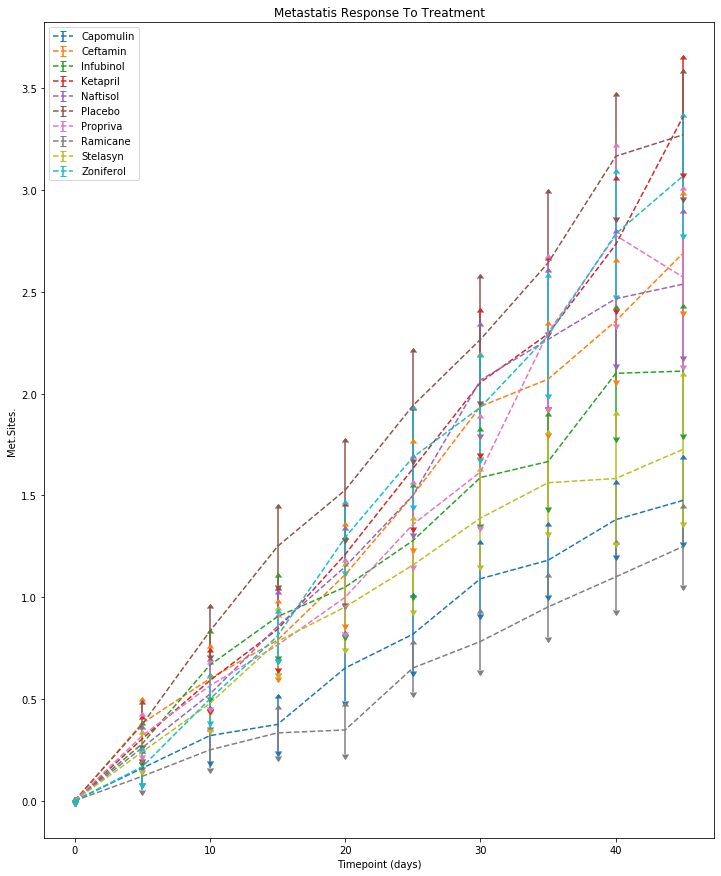

In [211]:
# Generate the Plot (with Error Bars)
plt.figure(figsize=(12,15))
plt.title('Metastatis Response To Treatment')


plt.xlabel('Timepoint (days)')
plt.ylabel('Met.Sites.')
#xaxis = df.Timepoint.unique()
for col in T_met_site_mean:
    plt.errorbar(xaxis, T_met_site_mean[col], yerr = T_met_site_sem[col], uplims=True, lolims=True,label = col, linestyle = '--')
plt.legend()

plt.show()
# Save the Figure

# Show the Figure


![Metastatic Spread During Treatment](../Images/spread.png)

## Survival Rates

In [167]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
mic = 'Mouse ID'
m = group_count(df, col_list, mic)
T_m = tranpose_multindex(m, mic)

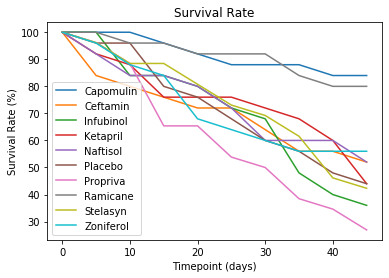

In [168]:
# Generate the Plot (Accounting for percentages)

plt.title('Survival Rate')

plt.xlabel('Timepoint (days)')
plt.ylabel('Survival Rate (%)')
#xaxis = df.Timepoint.unique()
for col in T_m:
    plt.errorbar(xaxis, ((T_m[col]/T_m.loc[0, col]) * 100), uplims=True, lolims=True, label = col)
plt.legend()

plt.show()

![Metastatic Spread During Treatment](../Images/survival.png)

## Summary Bar Graph

In [169]:
# Calculate the percent changes for each drug

In [170]:
drug_list = []
change_list = []
for col in T_tum_vol:
    drug_list.append(col)
    change_list.append((T_tum_vol.loc[45, col] - T_tum_vol.loc[0, col]) / T_tum_vol.loc[0, col])

change_per = [ "{:.2%}".format(e) for e in change_list]

change_df = pd.DataFrame({"Percent": [e * 100 for e in change_list],
                          "Percent Change" : change_per}, index = drug_list)
# Display the data to confirm
change_df

,Percent,Percent Change
Capomulin,-19.475303,-19.48%
Ceftamin,42.516492,42.52%
Infubinol,46.123472,46.12%
Ketapril,57.028795,57.03%
Naftisol,53.923347,53.92%
Placebo,51.297960,51.30%
Propriva,47.241175,47.24%
Ramicane,-22.320900,-22.32%
Stelasyn,52.085134,52.09%
Zoniferol,46.579751,46.58%


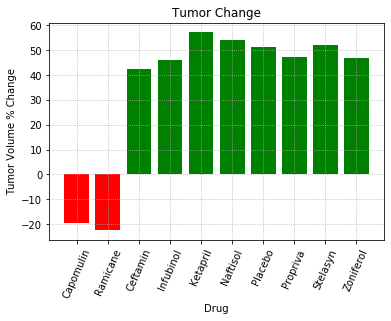

In [194]:
# Store all Relevant Percent Changes into a Tuple
plt.title('Tumor Change')

plt.xlabel('Drug')
plt.ylabel('Tumor Volume % Change')

neg_per_drugs = change_df[change_df['Percent'] < 0]

pos_per_drugs = change_df[change_df['Percent'] >= 0]

plt.grid(linestyle='dotted')
plt.bar(neg_per_drugs.index.values, neg_per['Percent'], color='r')
plt.bar(pos_per_drugs.index.values, pos_per['Percent'], color='g')


plt.xticks(rotation = 66)

plt.savefig('Tumor_change_Per.png')

plt.show()

# Splice the data between passing and failing drugs

# Orient widths. Add labels, tick marks, etc. 


# Use functions to label the percentages of changes


# Call functions to implement the function calls


# Save the Figure


# Show the Figure
#fig.show()